In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import cartopy 
import numpy as np
import xarray as xr
from datetime import datetime
from datetime import timedelta
from glob import glob
from parcels import (grid, Field, FieldSet, VectorField, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4, ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)


#Open the file with the buoy data:
file = open('df.pkl','rb')
df = pd.read_pickle('df.pkl')



In [2]:
print(df.datetime[:295])

1      2013-05-15 18:00:00
2      2013-05-16 00:00:00
3      2013-05-16 06:00:00
4      2013-05-16 12:00:00
5      2013-05-16 18:00:00
              ...         
291    2013-07-27 06:00:00
292    2013-07-27 12:00:00
293    2013-07-27 18:00:00
294    2013-07-28 00:00:00
295    2013-07-28 06:00:00
Name: datetime, Length: 295, dtype: string


In [3]:
"""
Function for easily setting fieldsets from Global Ocean Physical Reanalysis data in Parcels.
"""
def create(startDate, months, lonRange=(-65, -45), latRange=(55,65), **kwargs):
    """
    Creates a parcels.FieldSet object from hydrodynamic data in a netCDF file.
    
    Parameters
    ----------
    startDate : str, int
        String or int indicating the first date to load (YYYYMM)
    months : int
        Number of months to load    

        
    Returns
    ----------
    parcels.FieldSet    
    """
    readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
    fieldFiles = sorted(glob(readDir + "*.nc"))
    startFile = glob(readDir + f"mercatorglorys12v1_gl12_mean_{startDate}.nc")
    assert len(startFile) == 1, "No file found for this `start_date`."
    startFileIndex = fieldFiles.index(startFile[0])
    endFileIndex = startFileIndex + months
    if endFileIndex >= len(fieldFiles) - 1:
        days = len(fieldFiles) - startFileIndex -1
        endFileIndex = len(fieldFiles) - 1
        warnings.warn("\n Timespan of simulation exceeds the amount of data that is available. " \
                     +"Reducing the amount of `days` to " + str(months) +".")
    selectedFiles = fieldFiles[startFileIndex:endFileIndex]
    variables = {'U' : 'uo',
                 'V' : 'vo'}
    dimensions = {'U': {'time' : 'time',
                        'lat' : 'latitude',
                        'lon' : 'longitude',
                       'depth': 'depth'},
                  'V': {'time' : 'time',
                        'lat' : 'latitude',
                        'lon' : 'longitude',
                       'depth': 'depth'}}
    mesh = fieldFiles[0]
    filenames = {'U' : {'lon' : mesh, 
                        'lat' : mesh, 
                        'data' : selectedFiles},
                 'V' : {'lon' : mesh, 
                        'lat' : mesh, 
                        'data' : selectedFiles}}  
    
    ds = xr.open_dataset(fieldFiles[0])
    
    minLonIdx = np.searchsorted(ds.longitude, lonRange[0]) 
    maxLonIdx = np.searchsorted(ds.longitude, lonRange[1])
    minLatIdx = np.searchsorted(ds.latitude, latRange[0]) 
    maxLatIdx = np.searchsorted(ds.latitude, latRange[1])
    
    indices = {'lon' : range(minLonIdx, maxLonIdx),
               'lat' : range(minLatIdx, maxLatIdx),
               'depth' : [9]}
    fieldset = FieldSet.from_netcdf(selectedFiles, 
                                    variables, 
                                    dimensions, 
                                    indices = indices,
                                    allow_time_extrapolation = True,
                                   )

    
    fieldset.computeTimeChunk(fieldset.U.grid.time[0], 1)
    
    fieldset.landMask = np.isnan(ds.uo[0, 0, minLatIdx:maxLatIdx, minLonIdx:maxLonIdx].data)
    ds.close()
    return fieldset

In [6]:

filename = '/nethome/4276361/thesis/Mean_velocities_eulerian.nc'
variables = {'U' : 'uo',
             'V' : 'vo'}
dimensions = {'U': {'time' : 'time',
                    'lat' : 'latitude',
                    'lon' : 'longitude'},
              'V': {'time' : 'time',
                    'lat' : 'latitude',
                    'lon' : 'longitude'}}
#mesh = fieldFiles[0]
filenames = {'U' : filename,
             'V' : filename}  

fieldset = FieldSet.from_netcdf(filename, 
                                variables, 
                                dimensions,
                                allow_time_extrapolation = True,
                               )
fieldset.computeTimeChunk(fieldset.U.grid.time[0], 1)

5097600.0

In [38]:
#Create fieldset with the function above
#fieldset=create(201301,50)

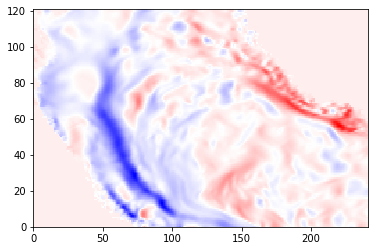

In [7]:
#Plot the fieldset at a certain time
data = fieldset.V.data

plt.pcolormesh(data[1,:,:], cmap='bwr')



In [8]:
class BuoyParticle(JITParticle):
    Age=Variable('Age',initial=0)

In [9]:
#PARTICLE SET
pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=BuoyParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=df.lon[:295], # a vector of release longitudes 
                             lat=df.lat[:295],    # a vector of release latitudes
                              time=pd.to_datetime(df.datetime[:295]))

In [10]:
print(pset)

P[0](lon=-50.327999, lat=58.575001, depth=0.000000, Age=0.000000, time=10303200.000000)
P[1](lon=-50.316002, lat=58.553001, depth=0.000000, Age=0.000000, time=10324800.000000)
P[2](lon=-50.316002, lat=58.542999, depth=0.000000, Age=0.000000, time=10346400.000000)
P[3](lon=-50.249001, lat=58.526001, depth=0.000000, Age=0.000000, time=10368000.000000)
P[4](lon=-50.205002, lat=58.492001, depth=0.000000, Age=0.000000, time=10389600.000000)
P[5](lon=-50.176998, lat=58.467999, depth=0.000000, Age=0.000000, time=10411200.000000)
P[6](lon=-50.167000, lat=58.433998, depth=0.000000, Age=0.000000, time=10432800.000000)
P[7](lon=-50.161999, lat=58.394001, depth=0.000000, Age=0.000000, time=10454400.000000)
P[8](lon=-50.148998, lat=58.345001, depth=0.000000, Age=0.000000, time=10476000.000000)
P[9](lon=-50.137001, lat=58.283001, depth=0.000000, Age=0.000000, time=10497600.000000)
P[10](lon=-50.116001, lat=58.228001, depth=0.000000, Age=0.000000, time=10519200.000000)
P[11](lon=-50.077999, lat=58.15

In [11]:
def aging(particle, fieldset,time):
    particle.Age+=particle.dt
    if particle.Age>3600*24*10:
        particle.delete()

  

def deleteparticle(particle,fieldset,time):
    """ This function deletes particles as they exit the domain and prints a message about their attributes at that moment
    """
    
    #print('Particle '+str(particle.id)+' has died at t = '+str(time)+' at lon, lat, depth = '+str(particle.lon)+','+str(particle.lat)+', '+str(particle.depth))
    particle.delete()

age_kernel = pset.Kernel(aging)
 

In [12]:
#Execute the kernel and write to file
output_file = pset.ParticleFile(name="meanflowdisp2.nc", outputdt=3600) # the file name and the time step of the outputs
pset.execute(AdvectionRK4+age_kernel,                 # the kernel (which defines how particles move)
             runtime=3600*24*100,    # the total length of the run
             dt=600,      # the timestep of the kernel
             recovery= {ErrorCode.ErrorOutOfBounds:deleteparticle}, #delete particle when it gets out of the domain
             output_file=output_file)
output_file.close()

INFO: Compiled BuoyParticleAdvectionRK4aging ==> /tmp/parcels-5388/f7a48460aacc7f956f958b52e94be405_0.so
INFO: Temporary output files are stored in out-TQYDWBCL.
INFO: You can use "parcels_convert_npydir_to_netcdf out-TQYDWBCL" to convert these to a NetCDF file during the run.


100% |########################################################################|


In [13]:
print(pset)

In [14]:
#Open output file
ds = xr.open_dataset('meanflowdisp2.nc')
print(ds)

<xarray.Dataset>
Dimensions:     (obs: 242, traj: 295)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    Age         (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2.dev126+g6dd05b7
    parcels_mesh:           spherical


(55, 60)

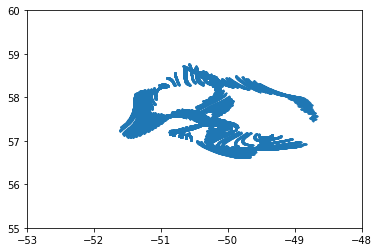

In [50]:
#plt.pcolormesh(np.linspace(-65,-45,240),np.linspace(55,65,120),fieldset.U.data[1,:,:], vmin=-0.01, vmax=0.01,cmap='bwr')
plt.scatter(ds.lon[:,:],ds.lat[:,:],s=1)
plt.xlim([-53,-48])
plt.ylim([55,60])

In [48]:
print(ds.Age[0,:])

<xarray.DataArray 'Age' (obs: 242)>
array([     0.,   3600.,   7200., ..., 860400., 864000., 864600.],
      dtype=float32)
Dimensions without coordinates: obs
Attributes:
    long_name:      
    standard_name:  Age
    units:          unknown
